# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import skforecast
import scipy.stats as ss
import xgboost      as xgb
import random
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble        import RandomForestRegressor
from xgboost                 import XGBRegressor



In [2]:
import warnings
warnings.filterwarnings ('ignore')

In [52]:
#pip install skforecast==0.4.2

## 0.1 fUNCIONES


In [5]:
def cramer_v(x,y):
    cm=pd.crosstab(x,y).to_numpy()
    n=cm.sum()
    r,k=cm.shape
    
    chi2=ss.chi2_contingency(cm)[0]
    chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
    
      
    return np.sqrt((chi2/n)/(min(k-1,r-1)))

def cramer_v_b(x,y):
    cm=pd.crosstab(x,y).to_numpy()
    n=cm.sum()
    r,k=cm.shape
    
    chi2=ss.chi2_contingency(cm)[0]
    chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr=k-(k-1)**2/(n-1)
    rcorr=r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def mean_percentage_error (y,yhat):
    return np.mean((y- yhat)/ y)

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs((y- yhat)/ y))

def ml_error (model_name, y, yhat):
    mae=mean_absolute_error (y,yhat)
    mape=mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model name': model_name, 'MAE': mae, 'MAPE':mape, 'RMSE': rmse}, index=[0])

def cross_validation (x_training, kfold, model_name, model, verbose = False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed (range(1, kfold+1)):
        if verbose:
            print('\n KFold Number: {}'. format(k))
        #fecha de validación de inicio y fin
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filto dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date']>= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #dataset training y validation
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #modelo
        m = model.fit(xtraining, ytraining)

        #predición
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error( model_name , np.expm1(yvalidation), np.expm1(yhat))

        #perfomance de store con interacion kfold
        mae_list.append  (m_result['MAE'])
        mape_list.append (m_result['MAPE'])
        rmse_list.append (m_result['RMSE'])

    return pd.DataFrame({'Nombre modelo': model_name,
                          'MAE CV': np.round(np.mean (mae_list), 2).astype(str) + '+/-' +  
                           np.round(np.std(mae_list),2).astype(str),
                          'MPAE CV': np.round(np.mean (mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list),                                   2).astype(str),
                          'RMSE CV': np.round(np.mean (rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list),    
                              2).astype(str)}, index=[0])

## 0.2 Descargando Datos


In [6]:
df_sales_raw= pd.read_csv('train.csv', low_memory=False)
df_store_raw=pd.read_csv('store.csv',low_memory=False)

#merge

df_raw=pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')
df_raw


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 DESCRIPCIÓN DE DATOS

In [7]:
df1=df_raw.copy()



## 1.1 Rename de columnas


In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))


df1.columns = cols_new

## 1.2 Dimensión de los datos


In [100]:
print(df1.shape[0], 'Registros' + ', ',df1.shape[1], 'Columnas')


1017209 Registros,  18 Columnas


## 1.3 Los tipos de datos


In [9]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verificando NA

In [102]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Analizando los NA


In [103]:
df1['competition_distance'].max()

75860.0

In [10]:
#competition_distance
df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
mes_mapa = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['mes_mapa']= df1['date'].dt.month.map(mes_mapa)

df1['es_promo'] = df1[['promo_interval', 'mes_mapa']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['mes_mapa'] in x['promo_interval'].split(',') else 0, axis=1)


In [11]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']= df1['promo2_since_week'].astype(int)
df1['promo2_since_year']= df1['promo2_since_year'].astype(int)

## 1.6 Descripción estadistica

In [12]:
num_attributes = df1.select_dtypes(include= ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

## 1.7.1 Atributos Numericos 

In [11]:
#Tendencia central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(num_attributes.apply( np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply( max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
                  
#concatenate
metricas = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

metricas.columns = ['attributes','min','max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
metricas

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


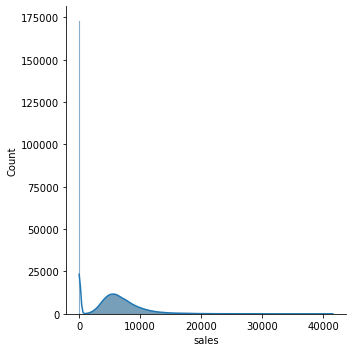

In [60]:
sns.displot(df1['sales'], kde=True);

## 1.7.1 Atributos Categoricos

In [61]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
mes_mapa          12
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

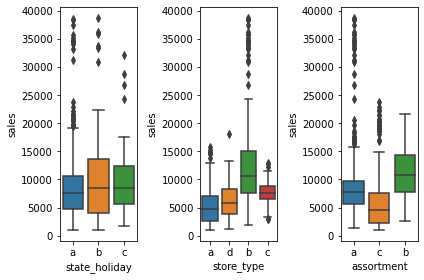

In [10]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales', data=aux1);

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales', data=aux1);

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales', data=aux1);

plt.tight_layout()
plt.show


# 2.0 Feature futuras

In [13]:
df2 = df1.copy()

## 2.1 Mapa Mental

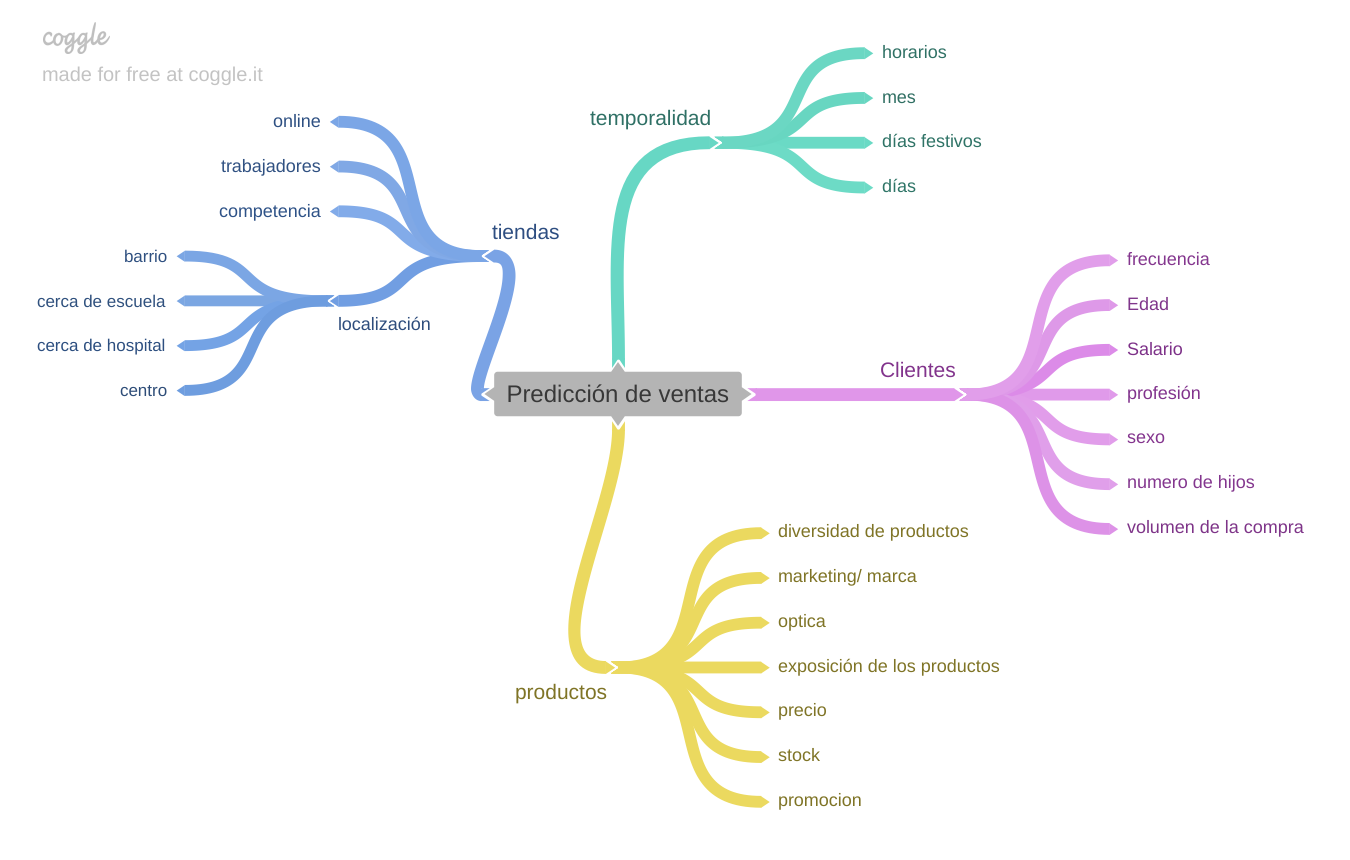

In [66]:
Image ('img\mindmap.png')

## 2.1 Hipotesis

### 1 - Las tiendas con más assortment deberían vender más
### 2 - Las tiendas con la competencia más cerca deberían vender menos
### 3 - Las tiendas con la competencia abierta más tiempo deberían vender más
### 4 - Las tiendas con promoción activas por más tiempodeberían vender más
### 5 - Las tiendas con más días de promociones deberían vender más
### 6 - Las tiendas con más promoción (promo2) consecutivas deberían vender más
### 7 - Las tiendas abiertas en Navidad deberían vender más
### 8 - Las tiendas deberían vender más con pasar de los años 
### 9 - Las tiendas deberían vender más en el 2 semestre
### 10 - Las tiendas deberían vender más después del día 10 de cada més
### 11 - Las tiendas deberían vender menos en los fines de semana
### 12 - Las teindas deberían vender menos en vacaciones escolares

## 2.2 Features futuras

In [14]:
#year
df2['year']= df2['date'].dt.year

#month
df2['month']= df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year']= df2['date'].dt.isocalendar().week 

#year_week
df2['year_week']= df2['date'].dt.strftime('%Y-%W')

#competition_since
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x ['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo2_since'] = df2['promo2_since_year'].astype(str ) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo2_since'])/7).apply(lambda x: x.days).astype( int)

#assortment
df2["assortment"].replace({"a":"basic","b":"extra","c":"extended"}, inplace=True)

#state_holiday
df2["state_holiday"].replace({"a":"public_holiday","b":"easter_holiday","c":"christmas", "0": "regular_day"}, inplace=True)

# 3.0 Filtro de variables

In [15]:
df3=df2.copy()

## 3.1 Filtro de lineas

In [16]:
df3 = df3[(df3['open'] != '0') & (df3['sales'] > 0)]

## 3.2 Filtro Columnas

In [17]:
cols_drop= ['customers', 'open','promo_interval', 'mes_mapa']
df3 = df3.drop( cols_drop, axis=1)

# 4.0 EDA

In [18]:
df4=df3.copy()

## 4.1 Analisis Univariable

### 4.1.1 Variable respuesta

C:\ProgramData\Anaconda3\envs\MLproyect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

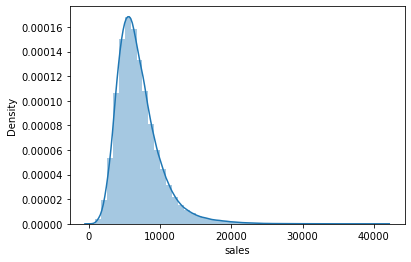

In [78]:
sns.distplot(df4['sales'])

### 4.1.2 Variable Numerica

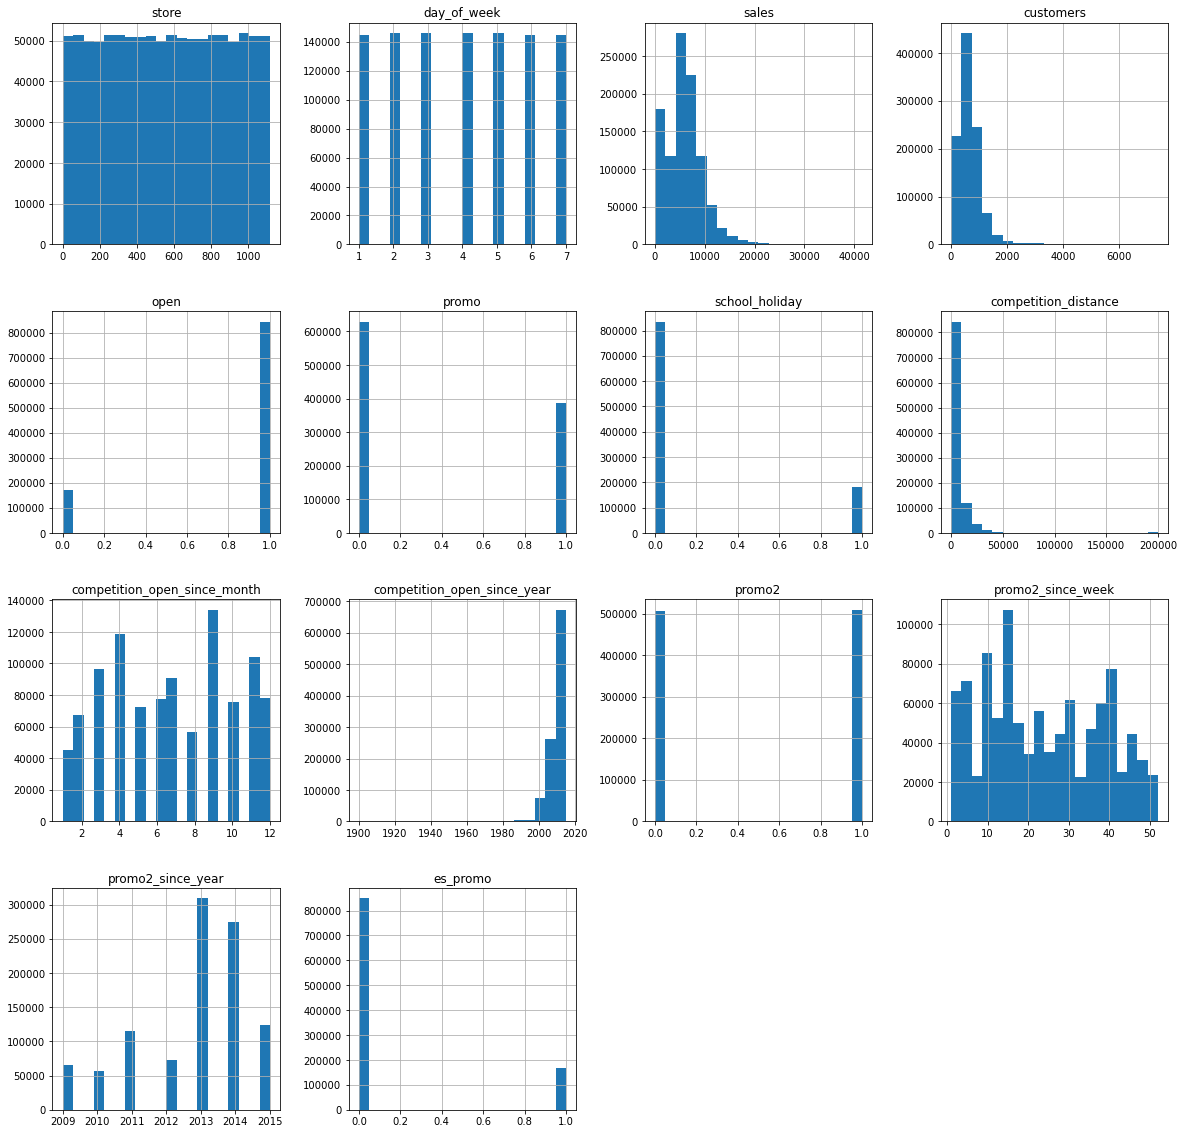

In [81]:
num_attributes.hist(bins= 20, figsize = (20,20));

### 4.1.3 Variable Categorica

In [84]:
df4['state_holiday'].drop_duplicates()

0         0
63559     a
129424    b
241126    c
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

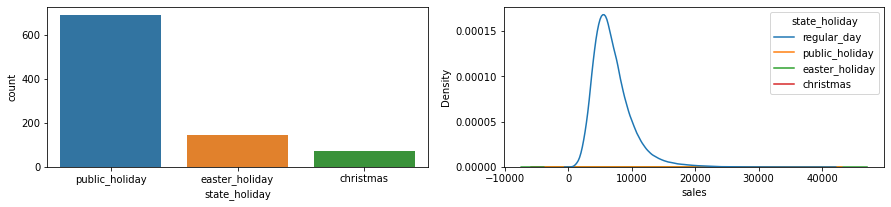

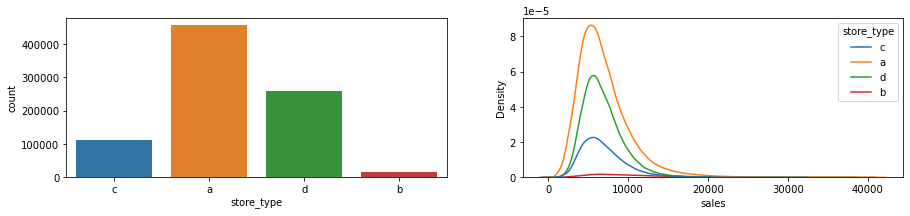

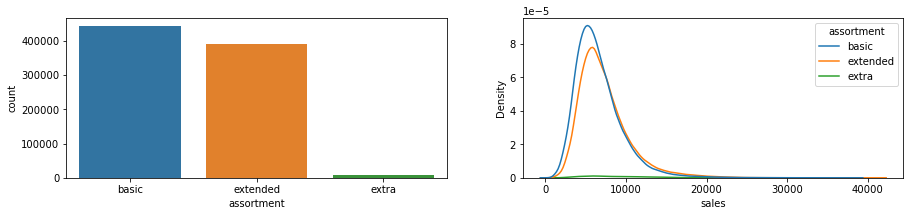

In [118]:
#state_holiday
fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(3, 2 , 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'])

plt.subplot(3, 2 , 2 )
sns.kdeplot(data=df4, x='sales', hue='state_holiday')

#store_type
fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(3, 2 , 3 )
sns.countplot(x=df4['store_type'])

plt.subplot(3, 2 , 4 )
sns.kdeplot(data=df4, x='sales', hue='store_type')


#assortment
fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(3, 2 , 5 )
sns.countplot(x=df4['assortment'])

plt.subplot(3, 2 , 6 )
sns.kdeplot(data=df4, x='sales', hue='assortment')


## 4.1 Analisis Bivariable

### H1 - Las tiendas con más assortment deberían vender más
### *Tiendas con más assortment venden menos

<AxesSubplot:xlabel='year_week'>

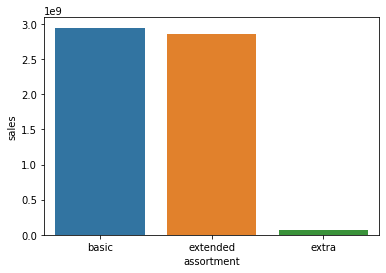

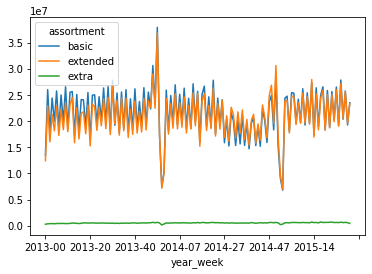

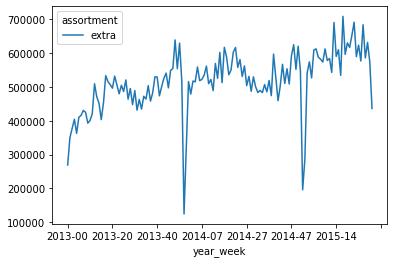

In [123]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


### H2 - Las tiendas con la competencia más cerca deberían vender menos
### *Tiendas con la competencia más cerca venden más


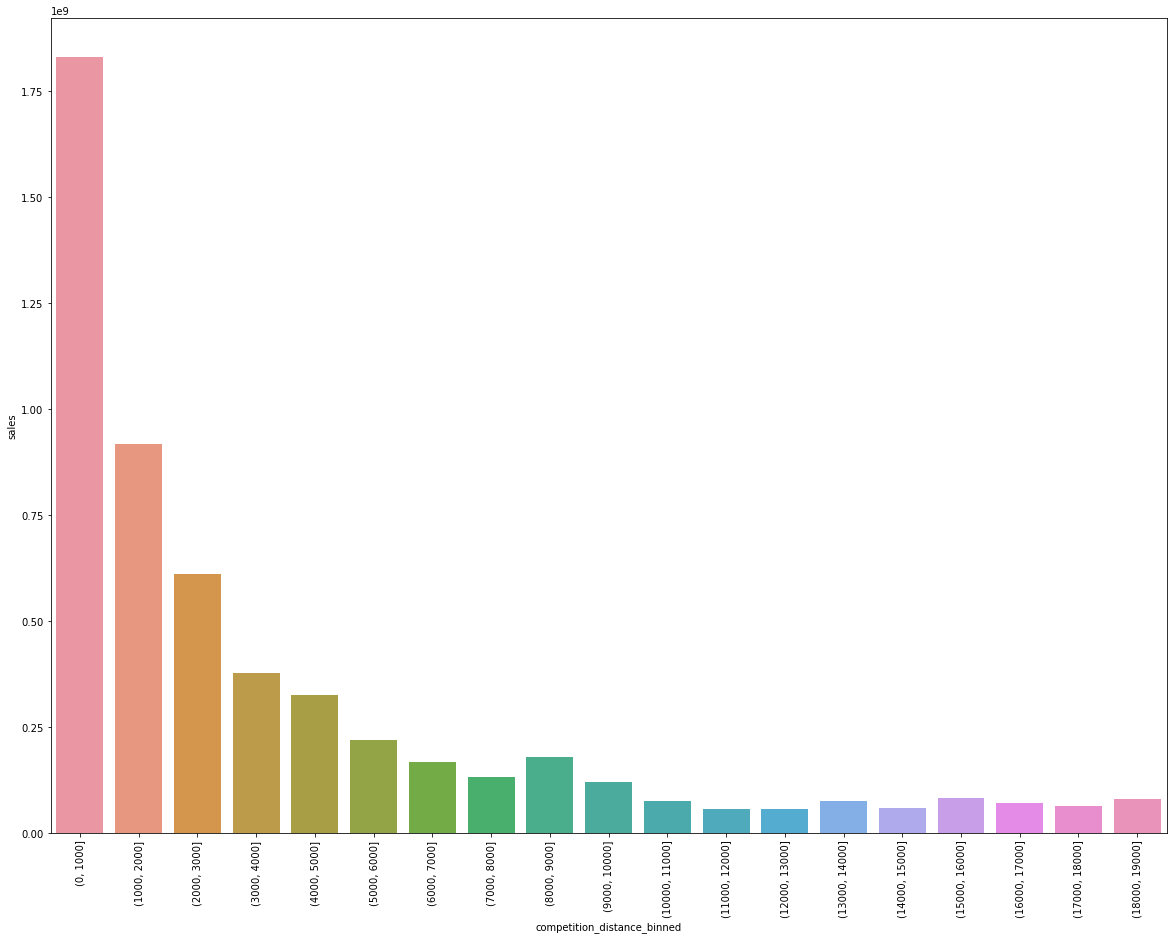

In [129]:
aux_4=df4[['competition_distance', 'sales']].groupby ('competition_distance').sum().reset_index()

bins=list(np.arange(0,20000,1000))

aux_4['competition_distance_binned']=pd.cut(aux_4['competition_distance'], bins=bins)
aux_5=aux_4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x='competition_distance_binned', y='sales', data=aux_5);
plt.xticks(rotation=90);


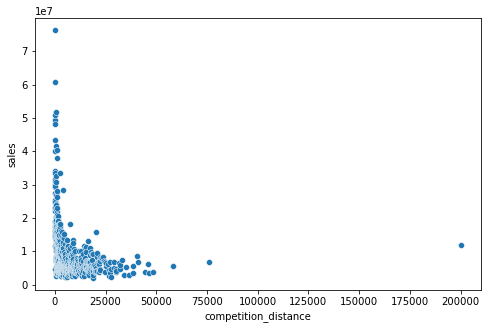

In [133]:

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x='competition_distance', y ='sales', data=aux_4);


<AxesSubplot:>

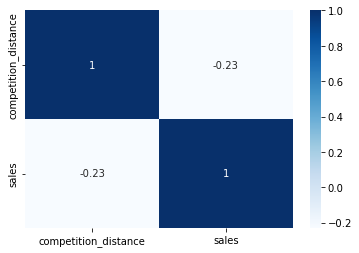

In [134]:
sns.heatmap(aux_4.corr(), annot=True, cmap="Blues")

### H3 - Las tiendas con la competencia abierta más tiempo deberían vender más
### *Tiendas con la competencia abierta más tiempo venden menos

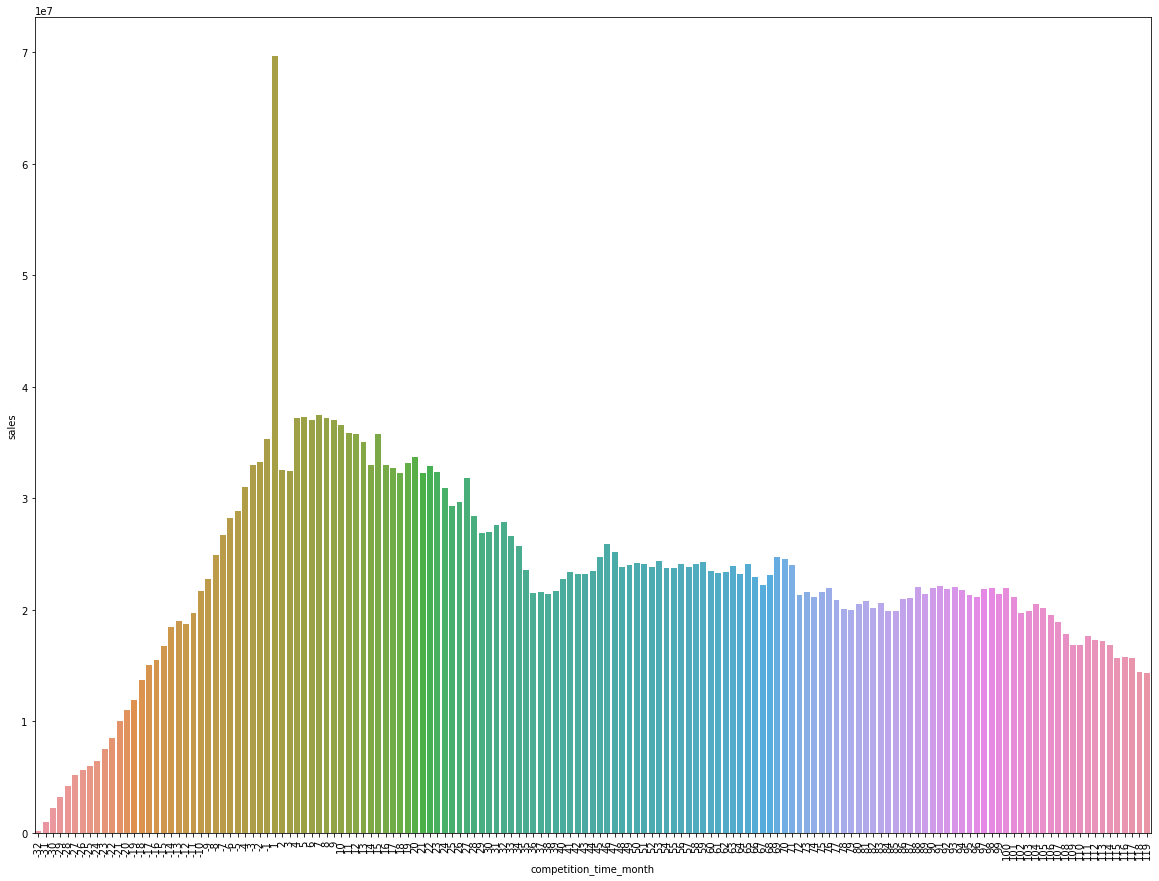

In [136]:
aux_6=df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux_7= aux_6[(aux_6['competition_time_month'] < 120) & (aux_6['competition_time_month'] != 0)]
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x= 'competition_time_month', y = 'sales', data= aux_7);
plt.xticks(rotation=90);

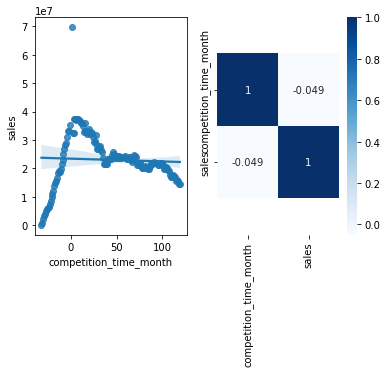

In [137]:
plt.subplot(1,2,1)
sns.regplot(x= 'competition_time_month', y = 'sales', data= aux_7);

plt.subplot(1,2,2)
x=sns.heatmap(aux_7.corr(), annot=True, cmap="Blues")
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H4 - Las tiendas con promoción activas por más tiempo deberían vender más
### *Tiendas con promoción activas por más tiempo venden menos.


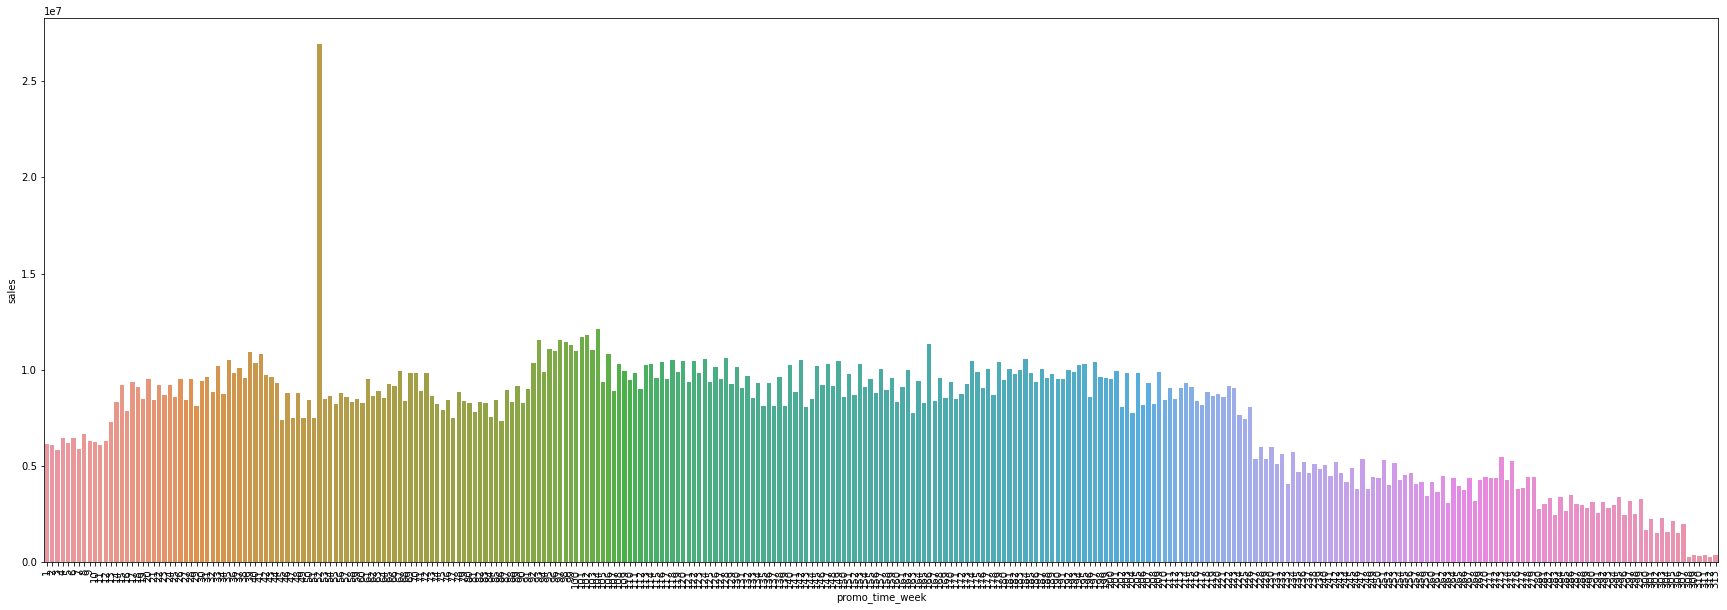

In [142]:
aux_8=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux_9=aux_8[aux_8['promo_time_week'] > 0 ]  
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x='promo_time_week', y='sales', data=aux_9);
plt.xticks(rotation=90);



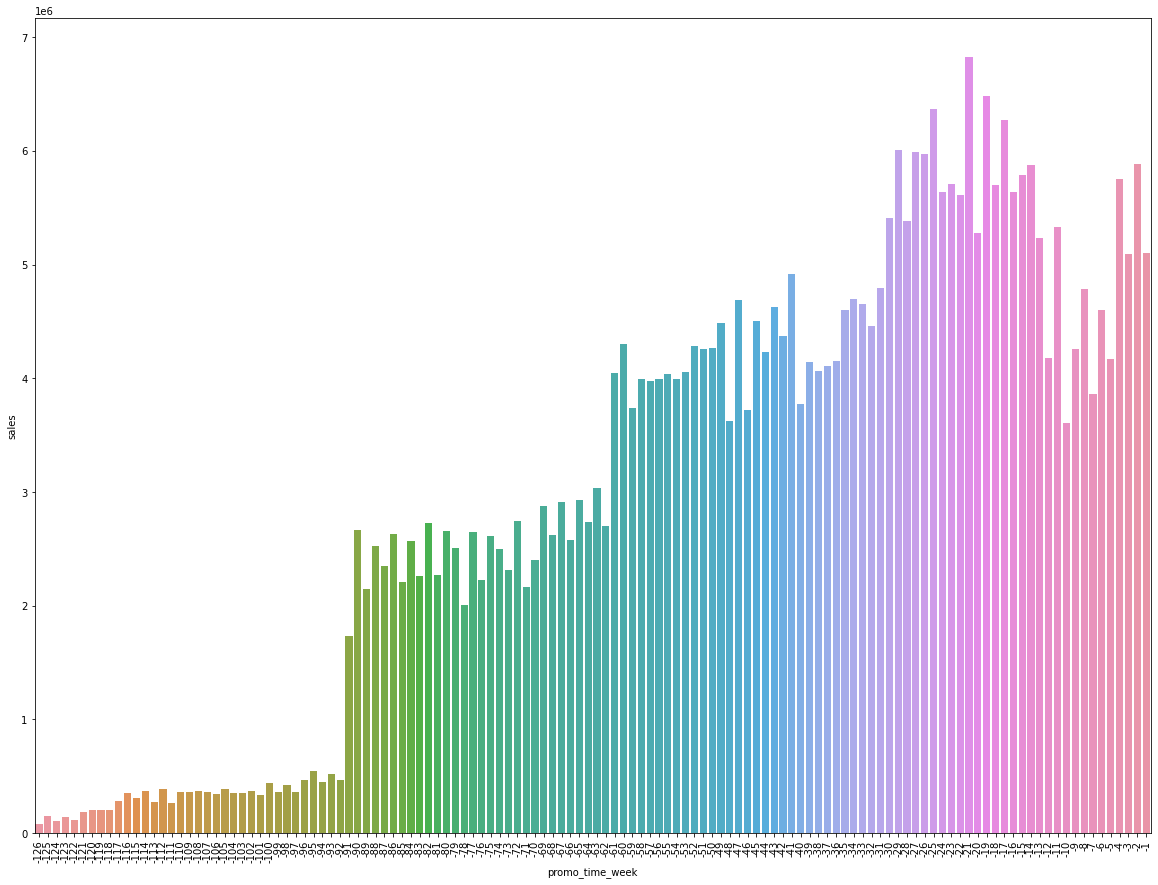

In [143]:
aux_10=aux_8[aux_8['promo_time_week']<0]  #promoción normal
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x='promo_time_week', y='sales', data=aux_10);
plt.xticks(rotation=90);

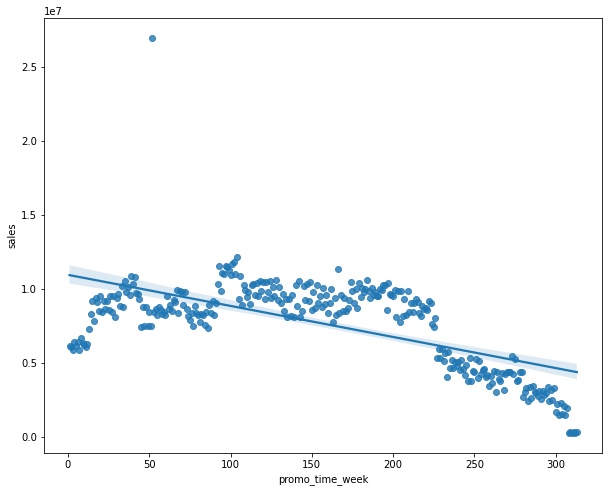

In [145]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='promo_time_week', y='sales', data=aux_9);


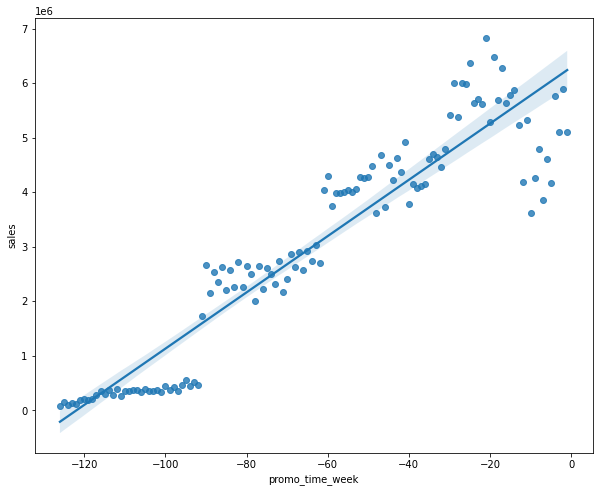

In [146]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='promo_time_week', y='sales', data=aux_10);

<AxesSubplot:>

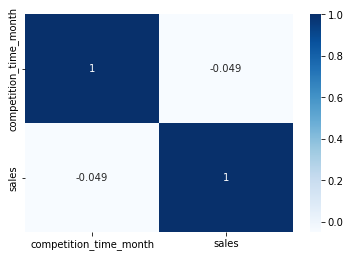

In [147]:
sns.heatmap(aux_7.corr(), annot=True, cmap="Blues");

### H6 - Las tiendas con más promoción (promo2) consecutivas deberían vender más
### *Tiendas con promoción consecutivas venden menos

In [149]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


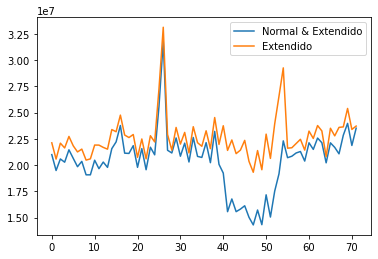

In [150]:
aux_11=df4[(df4['promo']==1) & (df3['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax=aux_11.plot()

aux_12=df4[(df4['promo']==1) & (df3['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux_12.plot(ax=ax)

ax.legend(labels=['Normal & Extendido', 'Extendido']);

### H7 - Las tiendas abiertas en Navidad deberían vender más
### *Tiendas abiertas durante Navidad venden menos


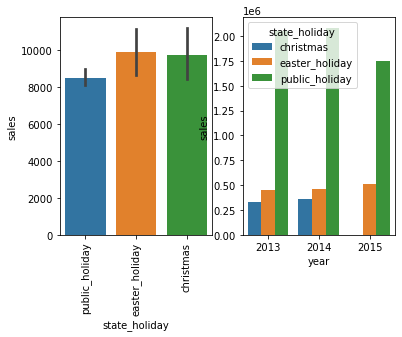

In [154]:
plt.subplot(1,2,1)
aux_13= df4[df4['state_holiday'] != 'regular_day']
df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux_13);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
aux_14= aux_13[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux_14);

### H8 - Las tiendas deberían vender más con pasar de los años
### *Tiendas venden más con el pasar de los años

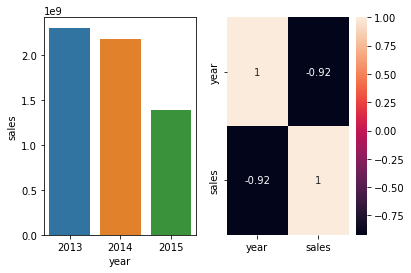

In [170]:
aux_15=df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,2, 1)
sns.barplot(x='year',y='sales', data=aux_15);

plt.subplot(1,2,2)
sns.heatmap(aux_15.corr(method='pearson'), annot=True); 

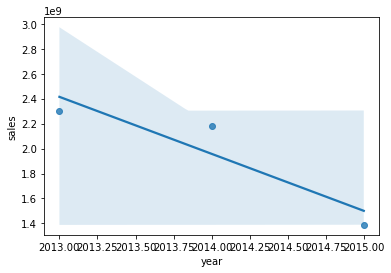

In [158]:
sns.regplot(x='year',y='sales', data=aux_15);

### H9 - Las tiendas deberían vender más en el 2 semestre
### *Tiendas venden menos en el 2 semestre

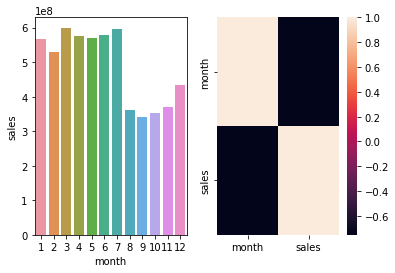

In [164]:
aux_16=df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='month',y='sales', data=aux_16);

plt.subplot(1,2,2)
sns.heatmap(aux_16.corr(method='pearson'));  

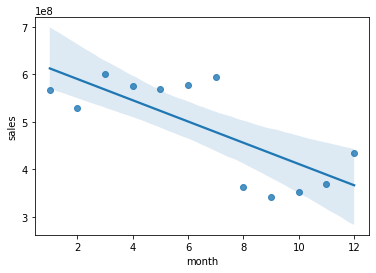

In [163]:
sns.regplot(x='month',y='sales', data=aux_16);

### H10 - Las tiendas deberían vender más después del día 10 de cada més
### *Tiendas venden más despues del día 10 de cada més


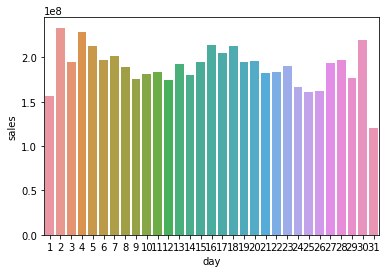

In [168]:
aux17 = df4[['day','sales']].groupby('day').sum().reset_index()

sns.barplot(x='day', y='sales', data= aux17);



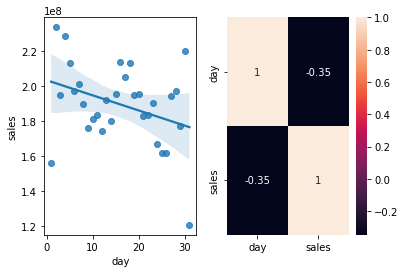

In [171]:
plt.subplot(1,2,1)
sns.regplot(x='day',y='sales', data=aux17);

plt.subplot(1,2,2)
sns.heatmap(aux17.corr(method='pearson'), annot=True);

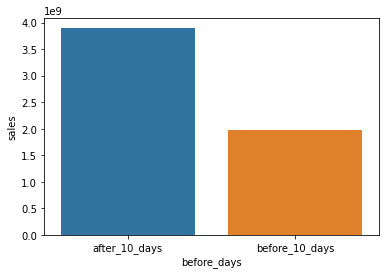

In [172]:
aux17['before_days']= aux17['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux18 = aux17[['before_days', 'sales']].groupby('before_days').sum().reset_index()
sns.barplot(x='before_days', y='sales', data=aux18);

### H11 - Las tiendas deberían vender menos en los fines de semana
### *Las tiendas venden menos en los fines de semana

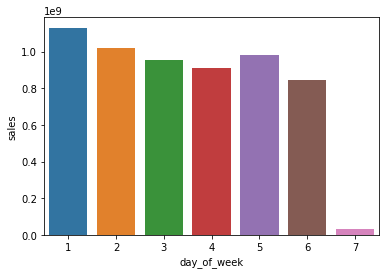

In [177]:
aux19 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week',y='sales', data=aux19);


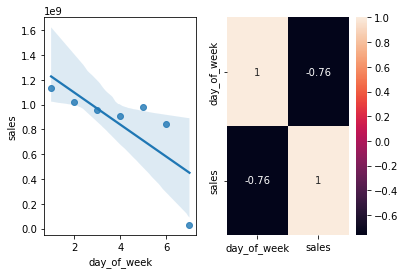

In [178]:
plt.subplot(1,2,1)
sns.regplot(x='day_of_week',y='sales', data=aux19);

plt.subplot(1,2,2)
sns.heatmap(aux19.corr(method='pearson'), annot=True);

### H12 - Las tiendas deberían vender menos en las vacaciones escolares
### *Las tiendas venden menos en las vacaiones escolares

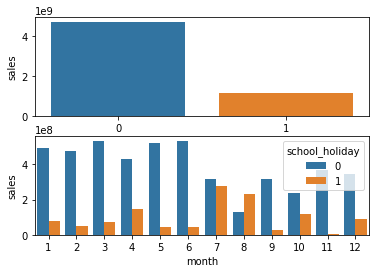

In [187]:
aux20 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales', data=aux20);

aux21= df4[['month','school_holiday','sales']]. groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales', hue='school_holiday', data=aux21);

## 4.3 Analisis Multivaribles

### 4.3.1 Atributos Numericos

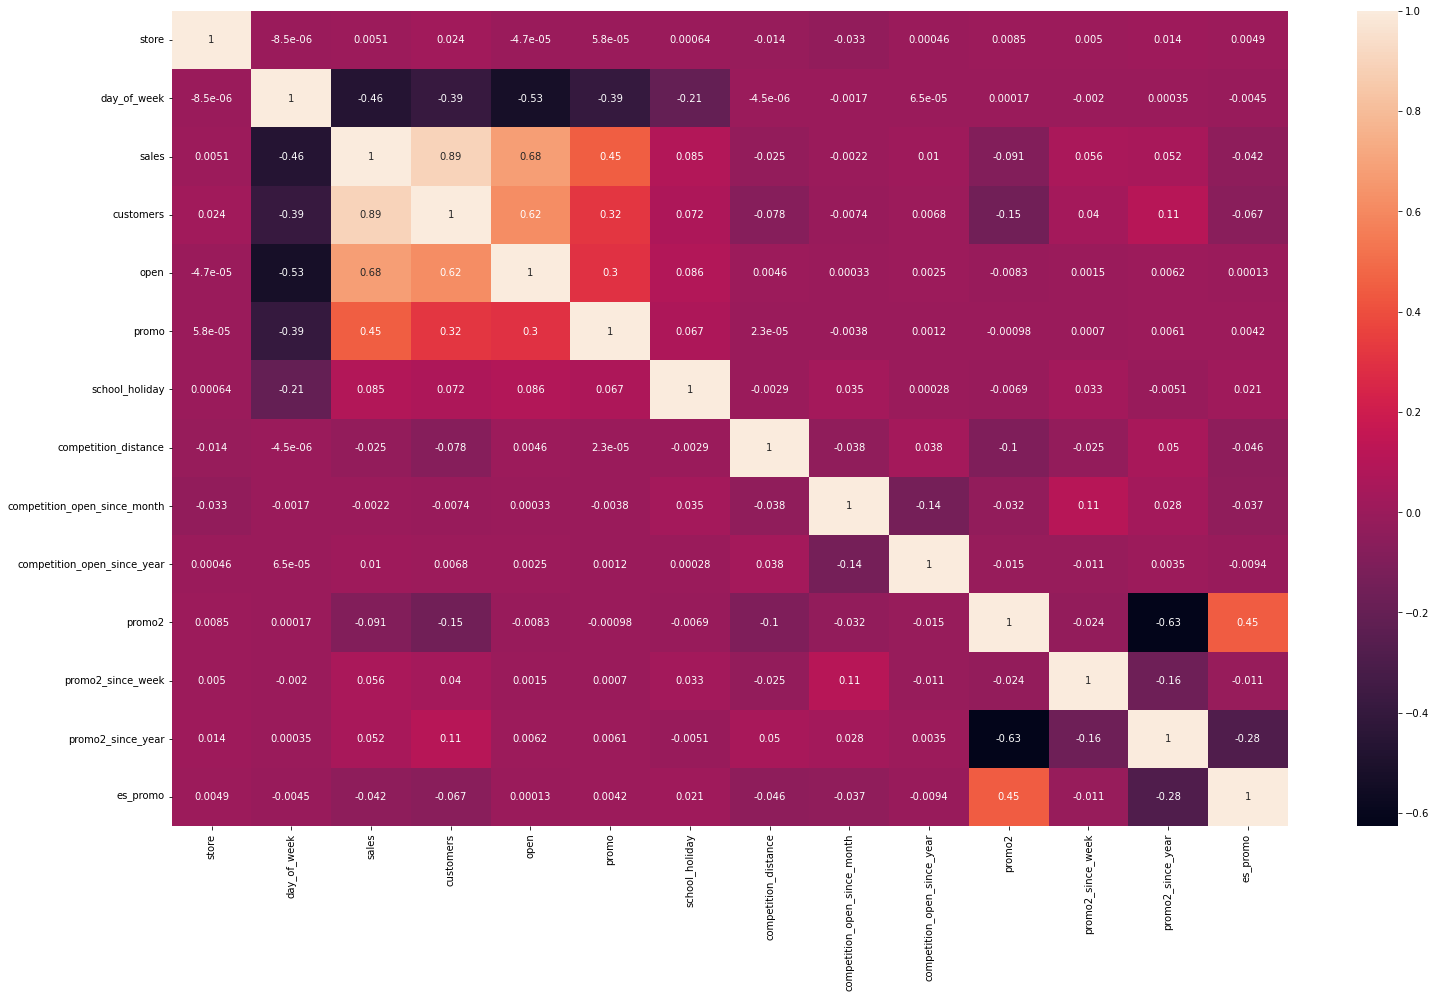

In [190]:
f, ax = plt.subplots(figsize=(25,15))
sns.heatmap(num_attributes.corr(), annot=True);

### 4.3.1 Atributos Categoricos

In [20]:
cat= df4.select_dtypes(include='object')
cat.head(3)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30


In [21]:
cramer_v(cat['state_holiday'], cat['store_type'])

0.07106457093267678

In [204]:
cramer_v_b(cat['state_holiday'], cat['store_type'])

0.07106469715258833

In [22]:
#claculando cramer v
a1=cramer_v_b(cat['state_holiday'], cat['state_holiday'])
a2=cramer_v_b(cat['state_holiday'], cat['store_type'])
a3=cramer_v_b(cat['state_holiday'], cat['assortment'])

a4=cramer_v_b(cat['store_type'], cat['state_holiday'])
a5=cramer_v_b(cat['store_type'], cat['store_type'])
a6=cramer_v_b(cat['store_type'], cat['assortment'])

a7=cramer_v_b(cat['assortment'], cat['state_holiday'])
a8=cramer_v_b(cat['assortment'], cat['store_type'])
a9=cramer_v_b(cat['assortment'], cat['assortment'])

#dataset final
matrix_cat= pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})

matrix_cat=matrix_cat.set_index(matrix_cat.columns)
matrix_cat

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


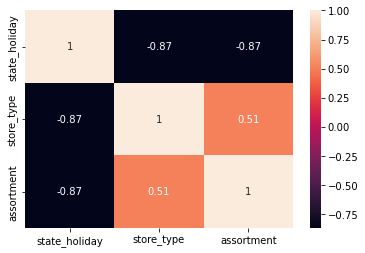

In [209]:
sns.heatmap(matrix_cat.corr(), annot=True);

## 5.0. Preparando los datos

In [23]:
df5=df4.copy()

## 5.1 Rescaling

In [24]:
df5['week_of_year'] =df5['week_of_year'].astype(int)

In [24]:
resca_num= df5.select_dtypes(include=['int64','int32','float64'])
resca_num.head(5)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,es_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


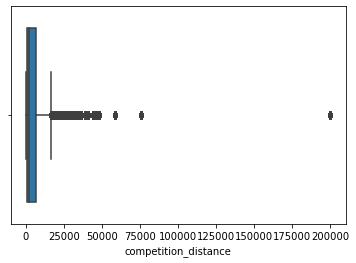

In [216]:
sns.boxplot(x = df5['competition_distance']);

In [25]:
rs= RobustScaler()
mms= MinMaxScaler()

#Competition_Distance
df5['competition_distance']=rs.fit_transform( df5[['competition_distance']].values)

#Competition_time_month
df5['competition_time_month']=rs.fit_transform( df5[['competition_time_month']].values)

#Promo_time_week
df5['promo_time_week']=mms.fit_transform( df5[['promo_time_week']].values)

#Year
df5['year']=mms.fit_transform( df5[['year']].values)

## 5.2. Encoding

In [26]:
#State_Holiday - one hot encoding
df5=pd.get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday'])

#Store_Type - Label Encoding
le = LabelEncoder()
df5['store_type']= le.fit_transform(df5['store_type'])

#Assortment - Ordinal Encoding
Assortment_dict = {'basic':1,'extra':2,'extended': 3}
df5['assortment']= df5['assortment'].map(Assortment_dict)

## 5.3. Transformando la variable respuesta

In [27]:
#ciclicos


#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2 * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2 * np.pi/52)))

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2 * np.pi/12)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2 * np.pi/7)))


In [28]:
df5['sales']=np.log1p(df5['sales'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


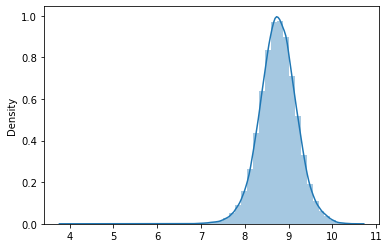

In [30]:
sns.distplot(x= df5['sales']);

# 6.0. Selección de las variables

In [29]:
df6 = df5.copy()

## 6.1. Split df entre train y test dataset

In [30]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week'] 
df6= df6.drop(cols_drop, axis=1)

In [111]:
df6[['store', 'date']].groupby ('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [31]:
#train
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print ('Train min: {} '.format(X_train ['date'].min()))
print ('Train max: {} '.format(X_train ['date'].max()))

print ('\nTest min: {} '.format(X_test ['date'].min()))
print ('Test max: {} '.format(X_test ['date'].max()))

Train min: 2013-01-01 00:00:00 
Train max: 2015-06-18 00:00:00 

Test min: 2015-06-19 00:00:00 
Test max: 2015-07-31 00:00:00 


## 6.2 Elección variable boruta

In [56]:
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor (n_jobs = -1)

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

In [ ]:
cols_select = boruta.support_.tolist()

#mejores selecciones
X_train_fs= X_train.drop(['date', 'sales'], axis=1)
cols_select_boruta = X_train_fs.iloc[:,cols_select].columns.to_list()

#peores
not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_select_boruta))

## 6.3 Elección manual de las variables

In [32]:
cols_select_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year', 
 'competition_time_month',
 'promo_time_week', 
 'day_sin', 
 'day_cos',
 'week_of_year_cos', 
 'week_of_year_sin',
 'month_sin',
 'month_cos', 
 'day_of_week_sin',
 'day_of_week_cos']

In [33]:
#anadir columnas
feat_to_add=['date', 'sales']

cols_select_full = cols_select_boruta.copy()
cols_select_full.extend(feat_to_add)


In [58]:
not_select_boruta = ['school_holiday','es_promo', 'year',
       'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day' ]

# 7.0 Modelo Machine Learning

In [34]:
x_train = X_train[cols_select_boruta]
x_test = X_test[cols_select_boruta]

#training
x_training = X_train [cols_select_full]

## 7.1 Modelo Averange

In [41]:
aux_1= x_test.copy()
aux_1['sales'] = y_test.copy()

#predicción
aux_2 = aux_1[['store', 'sales']].groupby('store').mean().reset_index().rename (columns={'sales':'predictions'})
aux_1 = pd.merge(aux_1,aux_2, how='left', on='store')
yhat_baseline = aux_1['predictions']

#performance
baseline_result = ml_error('Modelo Average', np.expm1(y_test), np.expm1(yhat_baseline))

In [42]:
baseline_result

,Model name,MAE,MAPE,RMSE
0,Modelo Average,1354.800353,0.455051,1835.135542


## 7.2 Regresión Linear

In [45]:
#model
lr = LinearRegression().fit( x_train, y_train)

#predicción
yhat_lr = lr.predict( x_test)

#performance
lr_result = ml_error ('Regresión Linear', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


,Model name,MAE,MAPE,RMSE
0,Regresión Linear,1884.41781,0.293986,2693.60806


### 7.2.1 Regresión Linear - Cross validation

In [161]:

lr_result_cv = cross_validation(x_training, 5, 'Regresion Linear', lr, verbose=False)
lr_result_cv

,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,Regresion Linear,2105.35+/-300.06,0.31+/-0.02,2981.13+/-473.04


## 7.3 Lasso

In [46]:
#model
lss = Lasso( alpha=0.01).fit( x_train, y_train)

#predicción
yhat_lss = lss.predict( x_test)

#performance
lss_result = ml_error ('Lasso', np.expm1(y_test), np.expm1(yhat_lss))
lss_result


,Model name,MAE,MAPE,RMSE
0,Lasso,1901.164158,0.289904,2756.54954


### 7.3.1 Lasso - Coss Validation

In [164]:
lss_result_cv = cross_validation(x_training, 5, 'Lasso', lss , verbose=False)
lss_result_cv

,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,Lasso,2127.43+/-342.27,0.29+/-0.01,3071.59+/-504.61


## 7.4 Random Forest 

In [58]:
#model
rf = RandomForestRegressor( n_estimators= 100, n_jobs=-1, random_state=42).fit( x_train, y_train)

#predicción
yhat_rf = rf.predict( x_test)

#performance
rf_result = ml_error ('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result


MemoryError: could not allocate 58720256 bytes

### 7.4.1 Randon Forest - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf , verbose=False)
rf_result_cv
#Random Forest MAE CV: 837.68+/-219.1  MAPE CV: 0.12+/-0.02 RMSE CV: 1256.08+/-320.36 

## 7.5 XGBoost

In [56]:
#model
xgb_model = xgb.XGBRegressor(n_estimators= 100, 
                             eta= 0.01,
                             max_depth = 10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit( x_train, y_train)

#predicción
yhat_xgb = xgb_model.predict( x_test)

#performance
xgb_result = ml_error ('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result


,Model name,MAE,MAPE,RMSE
0,XGBoost,6683.796901,0.949441,7331.371434


### 7.5.1 XGBoost - Cross Validation

In [168]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', xgb_model , verbose=False)
xgb_result_cv

,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,XGBoost,7049.24+/-588.48,0.95+/-0.0,7715.59+/-689.39


## 7.6 Comparación de los modelos

### 7.6.1 Performance simple

In [59]:
model_result = pd.concat([baseline_result, lr_result, lss_result, xgb_result ])
model_result.sort_values( 'RMSE')
#Random Forest MAE: 679.622763  MAPE: 0.099960 RMSE: 1011.191561 (Random Forest mejor)

,Model name,MAE,MAPE,RMSE
0,Modelo Average,1354.800353,0.455051,1835.135542
0,Regresión Linear,1884.417810,0.293986,2693.608060
0,Lasso,1901.164158,0.289904,2756.549540
0,XGBoost,6683.796901,0.949441,7331.371434


### 7.6.2 Performance real - Cross validation

In [170]:
model_result = pd.concat([lr_result_cv, lss_result_cv, xgb_result_cv ])
model_result
#Random Forest MAE CV: 837.68+/-219.1  MAPE CV: 0.12+/-0.02 RMSE CV: 1256.08+/-320.36 (mejor)

,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,Regresion Linear,2105.35+/-300.06,0.31+/-0.02,2981.13+/-473.04
0,Lasso,2127.43+/-342.27,0.29+/-0.01,3071.59+/-504.61
0,XGBoost,7049.24+/-588.48,0.95+/-0.0,7715.59+/-689.39


# 8.0 Hiperparametros Fine tuning

In [174]:
param = {
         'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
              }

MAX_EVAL = 2

In [176]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    #eligir parametros random
    hp = {k: random.sample (v,1)[0] for k, v in param.items()}
    print(hp)
    
    #model
    xgb_model = xgb.XGBRegressor(n_estimators= hp['n_estimators'], 
                                 eta= hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample= hp['subsample'],
                                 colsample_bytree= hp['colsample_bytree'],
                                 min_child_weight= hp['min_child_weight'])


    #performance
    result = cross_validation (x_training, 2, 'XGBoost' , xgb_model, verbose = False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 30, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 25, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,XGBoost,7194.29+/-128.44,0.96+/-0.0,7862.74+/-176.37
0,XGBoost,7416.23+/-128.28,1.0+/-0.0,8070.68+/-175.39


In [180]:
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
              }

MAX_EVAL = 10

In [181]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    #eligir parametros random
    hp = {k: random.sample (v,1)[0] for k, v in param.items()}
    print(hp)
    
    #model
    xgb_model = xgb.XGBRegressor(n_estimators= hp['n_estimators'], 
                                 eta= hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample= hp['subsample'],
                                 colsample_bytree= hp['colsample_bytree'],
                                 min_child_weight= hp['min_child_weight'])


    #performance
    result = cross_validation (x_training, 2, 'XGBoost' , xgb_model, verbose = False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9,

,Nombre modelo,MAE CV,MPAE CV,RMSE CV
0,XGBoost,1022.05+/-70.8,0.14+/-0.01,1467.94+/-126.03
0,XGBoost,849.1+/-82.75,0.11+/-0.01,1225.24+/-157.36
0,XGBoost,1432.08+/-53.24,0.19+/-0.0,2094.31+/-98.91
0,XGBoost,1049.61+/-54.56,0.14+/-0.0,1525.89+/-103.92
0,XGBoost,1475.0+/-44.48,0.2+/-0.0,2157.94+/-79.02
0,XGBoost,1736.46+/-49.88,0.24+/-0.0,2516.35+/-91.36
0,XGBoost,927.06+/-85.29,0.13+/-0.01,1325.69+/-142.2
0,XGBoost,835.06+/-81.36,0.11+/-0.01,1212.09+/-152.79
0,XGBoost,825.0+/-87.5,0.11+/-0.01,1199.42+/-159.9
0,XGBoost,1304.95+/-51.16,0.18+/-0.0,1904.11+/-95.72


## 8.2 Modelo Final

In [38]:
param_turned = {
         'n_estimators': 1500, 
         'eta': 0.03, 
         'max_depth': 9, 
         'subsample': 0.5, 
         'colsample_bytree': 0.7, 
         'min_child_weight': 15 
              }



In [39]:

#model
xgb_model_tuned = xgb.XGBRegressor(n_estimators= param_turned['n_estimators'], 
                            eta= param_turned['eta'],
                            max_depth = param_turned['max_depth'],
                            subsample= param_turned['subsample'],
                            colsample_bytree= param_turned['colsample_bytree'],
                            min_child_weight= param_turned['min_child_weight']).fit(x_train, y_train)
    
    
#prediccion
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error ( 'XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model name,MAE,MAPE,RMSE
0,XGBoost,639.502969,0.093643,940.680122


In [40]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.0037266771211144157

# 9.0 Traducción del error

In [43]:
df9 = X_test[cols_select_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Performance Business

In [46]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE y MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename (columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename (columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge (df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge (df91, df9_aux3, how = 'inner', on = 'store')

#escenario
df92['mejor escenario'] = df92['predictions'] - df92['MAE']
df92['peor escenario'] = df92['predictions'] + df92['MAE']

#columnas
df92 = df92[['store', 'predictions', 'peor escenario', 'mejor escenario', 'MAE', 'MAPE']]




In [49]:
df92.sample(4)

,store,predictions,peor escenario,mejor escenario,MAE,MAPE
645,646,186210.578125,186603.151004,185818.005246,392.572879,0.080918
145,146,309729.062500,310347.964158,309110.160842,618.901658,0.076557
1024,1025,264146.281250,264700.103819,263592.458681,553.822569,0.074573
537,538,141874.390625,142212.653050,141536.128200,338.262425,0.088139


In [50]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,peor escenario,mejor escenario,MAE,MAPE
291,292,105847.476562,109179.525635,102515.427490,3332.049072,0.562643
908,909,235177.515625,242719.838336,227635.192914,7542.322711,0.502954
594,595,344461.031250,349454.327940,339467.734560,4993.296690,0.344113
875,876,201982.953125,205964.146601,198001.759649,3981.193476,0.304998
721,722,345516.875000,347306.628405,343727.121595,1789.753405,0.241336


<AxesSubplot:xlabel='store', ylabel='MAPE'>

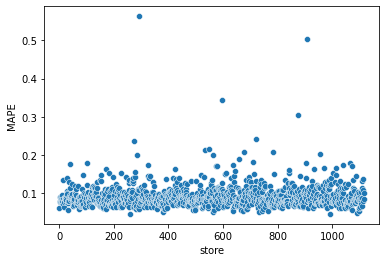

In [51]:
sns.scatterplot(x='store', y='MAPE', data = df92)

## 9.2 Performance Total

In [56]:
df93 = df92[['predictions', 'peor escenario', 'mejor escenario']].apply(lambda x: np.sum(x), axis =0).reset_index().rename(columns = {'index':'escenario', 0:'valores'})
df93['valores'] = df93['valores'].map('€{:,.2f}'.format)
df93

,escenario,valores
0,predictions,"€285,108,736.00"
1,peor escenario,"€285,825,519.86"
2,mejor escenario,"€284,391,956.81"


## 9.3 Performance del ML 

In [57]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

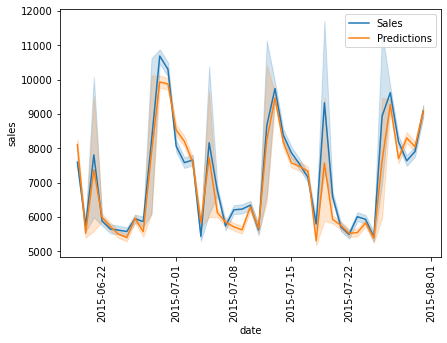

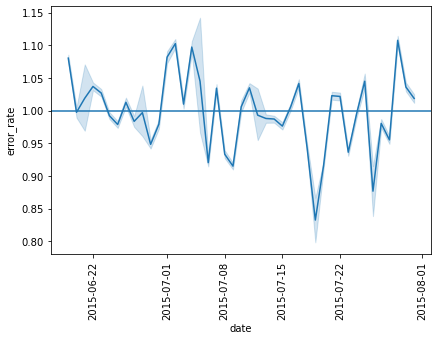

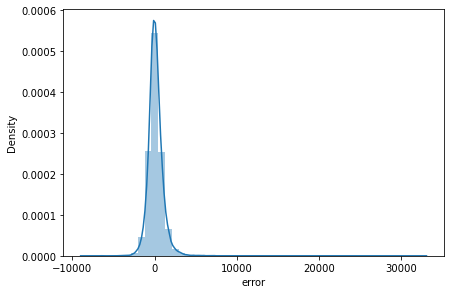

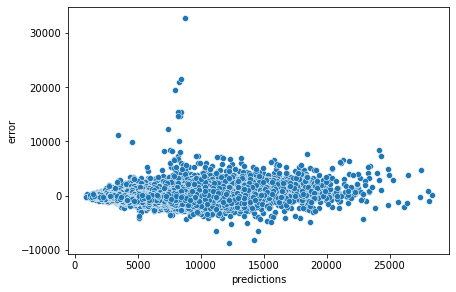

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(2,2,1)
sns.lineplot (x='date', y='sales', data=df9, label='Sales')
sns.lineplot (x='date', y='predictions', data=df9, label='Predictions')
plt.xticks(rotation=90);

fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(2,2,2)
sns.lineplot (x='date', y='error_rate', data=df9)
plt.axhline(y=1); #axhline(1, linesty)
plt.xticks(rotation=90);

fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(2,2,3)
sns.distplot (df9['error']);

fig, ax = plt.subplots(figsize=(15,10))
plt.subplot(2,2,4)
sns.scatterplot (df9['predictions'], df9['error']);
